In [1]:
from joblib import Parallel, delayed
from numpy.typing import NDArray
import numpy as np
from dataclasses import dataclass

from functools import partial

from fspb.bands.band import Band, BandType, BandOptions, DistributionType
from fspb.types import CovarianceType, EstimationMethod
from fspb.simulation.model_simulation import (
    SimulationData,
    generate_default_time_grid,
    simulate_from_model,
)
from fspb.simulation.simulation_study import SimulationOptions
from fspb.config import LENGTH_SCALE


In [2]:
results = {}

for band_type in BandType:

    for distribution_type in DistributionType:

        simulation_options = SimulationOptions(
            n_samples=1_000,
            dof=5,
            covariance_type=CovarianceType.STATIONARY,
            length_scale=LENGTH_SCALE,
        )

        band_options = BandOptions(
            band_type=band_type,
            interval_cutoffs=np.array([1/3, 2/3]),
            significance_level=0.05,
            distribution_type=distribution_type,
            norm_order=2
        )


        rng = np.random.default_rng(42)

        time_grid = generate_default_time_grid()


        data = simulate_from_model(
            n_samples=simulation_options.n_samples,
            time_grid=time_grid,
            dof=simulation_options.dof,
            covariance_type=simulation_options.covariance_type,
            length_scale=simulation_options.length_scale,
            rng=rng,
        )

        new_data = simulate_from_model(
            n_samples=1,
            time_grid=time_grid,
            dof=simulation_options.dof,
            covariance_type=simulation_options.covariance_type,
            length_scale=simulation_options.length_scale,
            rng=rng,
        )

        print(f"{band_type} - {distribution_type}")

        band_fair = Band.fit(
            y=data.y,
            x=data.x,
            x_new=new_data.x,
            band_type=band_options.band_type,
            time_grid=time_grid,
            interval_cutoffs=band_options.interval_cutoffs,
            significance_level=band_options.significance_level,
            distribution_type=band_options.distribution_type,
            norm_order=band_options.norm_order,
            method=EstimationMethod.FAIR,
        )

        band_min_width = Band.fit(
            y=data.y,
            x=data.x,
            x_new=new_data.x,
            band_type=band_options.band_type,
            time_grid=time_grid,
            interval_cutoffs=band_options.interval_cutoffs,
            significance_level=band_options.significance_level,
            distribution_type=band_options.distribution_type,
            norm_order=band_options.norm_order,
            method=EstimationMethod.MIN_WIDTH,
        )

        results[(band_type, distribution_type)] = {
            "band_fair": band_fair,
            "band_min_width": band_min_width,
        }

confidence - gaussian
confidence - student_t
prediction - gaussian
prediction - student_t


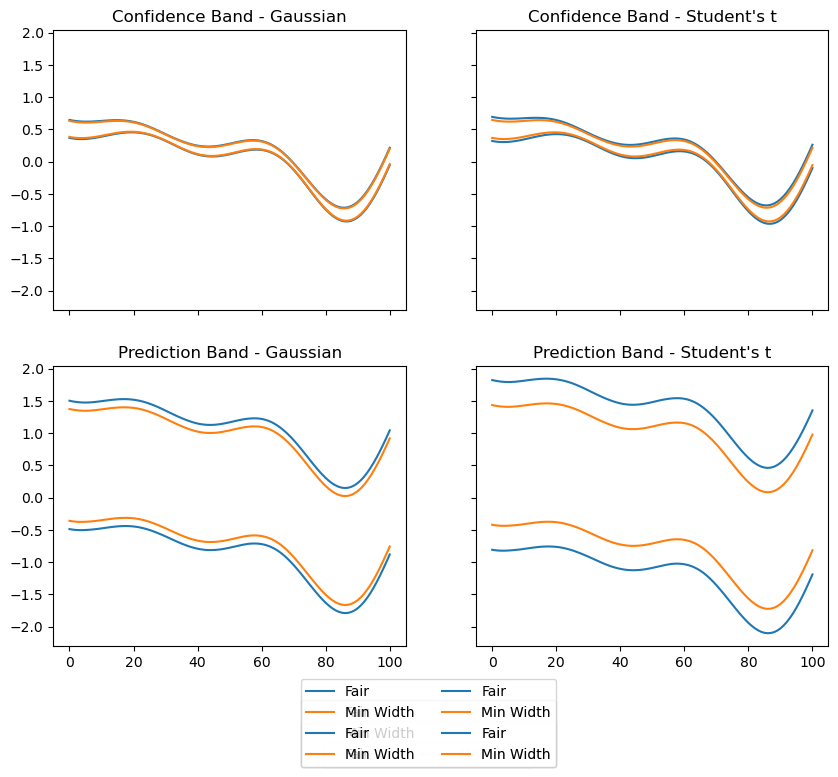

In [3]:
import matplotlib.pyplot as plt
import itertools

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), sharex=True, sharey=True)

for (band_type, distribution_type), result in results.items():
    band_fair = result["band_fair"]
    band_min_width = result["band_min_width"]

    if band_type == BandType.CONFIDENCE:
        if distribution_type == DistributionType.GAUSSIAN:
            ax = axes[0, 0]
            ax.set_title("Confidence Band - Gaussian")
        else:
            ax = axes[0, 1]
            ax.set_title("Confidence Band - Student's t")
    else:
        if distribution_type == DistributionType.GAUSSIAN:
            ax = axes[1, 0]
            ax.set_title("Prediction Band - Gaussian")
        else:
            ax = axes[1, 1]
            ax.set_title("Prediction Band - Student's t")

    ax.plot(band_fair.lower, color="tab:blue", label="Fair")
    ax.plot(band_fair.upper, color="tab:blue")

    ax.plot(band_min_width.lower, color="tab:orange", label="Min Width")
    ax.plot(band_min_width.upper, color="tab:orange")

    fig.legend(loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2)